In [1]:
import numpy as np
import pandas as pd
import polars as pl

## Loading in Georgetown Historic District Data

This is not the full list. I dropped about 382 projects due to misalignment between location and coordinates, and missing project_descriptions. 

Let me know if any more do not align by [emailing](mailto:qcp6az@virginia.edu) me!

In [2]:
og = pd.read_csv('old_georgetown_board_projects.csv')
og.head()

,project_number,project_type,project_description,last_reviewed,project_location_clean,Coordinates_lat_lon
0,OG 25-038,Commercial,Sign - Canal House,2024-11-21T12:00:00Z,1023-1029 31st street nw,"(38.9032644, -77.060821)"
1,OG 25-037,Georgetown,Shaw Field lights,2024-11-21T12:00:00Z,3700 o street nw,"(38.90893925, -77.07457962060826)"
2,OG 25-036,Residence,Egress window well on west elevation,2024-11-21T12:00:00Z,3321 q street nw,"(38.9108942, -77.06688820187202)"
3,OG 25-034,Residence,Shutter and door replacements,2024-11-21T12:00:00Z,3306 o street nw,"(38.907624049999995, -77.06655487369912)"
4,OG 25-033,Residential,Landscape alterations and stair revision,2024-11-21T12:00:00Z,3114 r street nw,"(38.91330825, -77.0637584339222)"


In [3]:
print(og.head())

  project_number project_type                       project_description  \
0      OG 25-038   Commercial                        Sign - Canal House   
1      OG 25-037   Georgetown                         Shaw Field lights   
2      OG 25-036    Residence      Egress window well on west elevation   
3      OG 25-034    Residence             Shutter and door replacements   
4      OG 25-033  Residential  Landscape alterations and stair revision   

          last_reviewed    project_location_clean  \
0  2024-11-21T12:00:00Z  1023-1029 31st street nw   
1  2024-11-21T12:00:00Z          3700 o street nw   
2  2024-11-21T12:00:00Z          3321 q street nw   
3  2024-11-21T12:00:00Z          3306 o street nw   
4  2024-11-21T12:00:00Z          3114 r street nw   

                        Coordinates_lat_lon  
0                  (38.9032644, -77.060821)  
1         (38.90893925, -77.07457962060826)  
2          (38.9108942, -77.06688820187202)  
3  (38.907624049999995, -77.06655487369912)  


In [4]:
og_pl = pl.read_csv('old_georgetown_board_projects.csv')

In [5]:
print(og_pl.head())

shape: (5, 6)
┌────────────────┬──────────────┬────────────────┬────────────────┬────────────────┬───────────────┐
│ project_number ┆ project_type ┆ project_descri ┆ last_reviewed  ┆ project_locati ┆ Coordinates_l │
│ ---            ┆ ---          ┆ ption          ┆ ---            ┆ on_clean       ┆ at_lon        │
│ str            ┆ str          ┆ ---            ┆ str            ┆ ---            ┆ ---           │
│                ┆              ┆ str            ┆                ┆ str            ┆ str           │
╞════════════════╪══════════════╪════════════════╪════════════════╪════════════════╪═══════════════╡
│ OG 25-038      ┆ Commercial   ┆ Sign - Canal   ┆ 2024-11-21T12: ┆ 1023-1029 31st ┆ (38.9032644,  │
│                ┆              ┆ House          ┆ 00:00Z         ┆ street nw      ┆ -77.060821)   │
│ OG 25-037      ┆ Georgetown   ┆ Shaw Field     ┆ 2024-11-21T12: ┆ 3700 o street  ┆ (38.90893925, │
│                ┆              ┆ lights         ┆ 00:00Z         ┆ nw       

## Data Preparation

#### Rename Columns

In [6]:
og.rename(columns={'last_reviewed':'date'},inplace=True)
og_pl = og_pl.with_columns(pl.col('last_reviewed').alias('date')).drop('last_reviewed')

#### Clean Up the Project Description Column to Get Activity

In [7]:
details_mapping = {
    "addition": "Addition",
    "install": "Addition",
    "construction": "Addition",
    "new ": "Addition",

    "repair": "Repair",
    "restore": "Repair",

    "alteration": "Alteration",
    "modif": "Alteration",
    "reconstruction": "Alteration",

    "demolition": "Demolition",

    "replace": "Renovation",
    "rebuild": "Renovation",
    "renovation": "Renovation"
}

for keyword, detail in details_mapping.items():
    if keyword == "construction":
        og.loc[og['project_description'].str.lower().str.contains(keyword) & ~og['project_description'].str.lower().str.contains("reconstruction"), 'activity'] = detail
    else:
        og.loc[og['project_description'].str.lower().str.contains(keyword), 'activity'] = detail

In [8]:
og['activity'].value_counts()

activity
Renovation    3492
Alteration    2634
Addition      2018
Demolition     267
Repair         142
Name: count, dtype: int64

#### Clean Up the Project Type Column

In [9]:
#Only look at the four most common property types
og['select_project_types'] = og['project_type'].apply(
    lambda x: x if x.lower() in ['residential', 'commercial', 'georgetown','mixed-use'] else None)
og.loc[og['project_type'].apply(lambda x: False if x is None else (True if 'residence' in x.lower() else False)), 'select_project_types'] = 'Residential'

#### Fix the Date Column

In [10]:
og['date'] = pd.to_datetime(og['date'])

In [11]:
og_pl = pl.from_pandas(og)

## Analysis

### **1. Find the 3 Most Common Actions by Property Type**

In [12]:
import re
from collections import Counter
import time
 
times_1_pandas = []
for _ in range(10000):
    start_time = time.time()

    # Filter for 2019 and 2020
    filtered = og[(og["date"].dt.year == 2020) | (og["date"].dt.year == 2019)]
    filtered = filtered.loc[filtered['select_project_types'].notnull() & filtered['activity'].notnull()]

    # Group by property_type and activity proportions
    activity_props = filtered.groupby('select_project_types')['activity'].value_counts(normalize=True)

    # Get top 3 words per property_type
    top_activity = activity_props.groupby("select_project_types").nlargest(3).reset_index(level=0, drop=True)
    end_time = time.time()

    times_1_pandas.append(end_time - start_time)


In [13]:
top_activity

select_project_types  activity  
Commercial            Addition      0.385593
                      Renovation    0.309322
                      Alteration    0.305085
Georgetown            Renovation    0.714286
                      Addition      0.107143
                      Repair        0.107143
Mixed-use             Addition      0.687500
                      Renovation    0.187500
                      Alteration    0.125000
Residential           Renovation    0.540752
                      Addition      0.272727
                      Alteration    0.167712
Name: proportion, dtype: float64

In [14]:
times_1_polars = []
for _ in range(10000):
    start_time = time.time()
    # Filter for 2019 and 2020
    filtered_pl = og_pl.filter(
        (pl.col("date").dt.year() == 2020) | (pl.col("date").dt.year() == 2019)
    ).filter(
        pl.col("select_project_types").is_not_null() & pl.col("activity").is_not_null()
    )

    # Group by property_type and activity proportions
    activity_props_pl = filtered_pl.group_by(["select_project_types", "activity"]).agg(
        pl.count().alias("proportion")
    ).with_columns(
        (pl.col("proportion") / pl.col("proportion").sum().over("select_project_types")).alias("proportion")
    )

    # Get top 3 activities per property_type
    top_activity_pl = activity_props_pl.group_by("select_project_types").head(3).sort(by = ['select_project_types','proportion'],descending=[False,True])
    end_time = time.time()

    times_1_polars.append(end_time - start_time)

C:\Users\finnr\AppData\Local\Temp\ipykernel_35256\516555410.py:13: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias("proportion")


In [15]:
print(top_activity_pl)

shape: (12, 3)
┌──────────────────────┬────────────┬────────────┐
│ select_project_types ┆ activity   ┆ proportion │
│ ---                  ┆ ---        ┆ ---        │
│ str                  ┆ str        ┆ f64        │
╞══════════════════════╪════════════╪════════════╡
│ Commercial           ┆ Addition   ┆ 0.385593   │
│ Commercial           ┆ Renovation ┆ 0.309322   │
│ Commercial           ┆ Alteration ┆ 0.305085   │
│ Georgetown           ┆ Renovation ┆ 0.714286   │
│ Georgetown           ┆ Repair     ┆ 0.107143   │
│ …                    ┆ …          ┆ …          │
│ Mixed-use            ┆ Renovation ┆ 0.1875     │
│ Mixed-use            ┆ Alteration ┆ 0.125      │
│ Residential          ┆ Renovation ┆ 0.540752   │
│ Residential          ┆ Alteration ┆ 0.167712   │
│ Residential          ┆ Repair     ┆ 0.015674   │
└──────────────────────┴────────────┴────────────┘


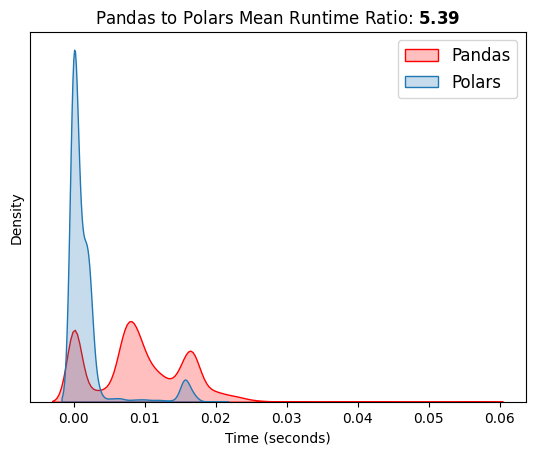

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(times_1_pandas, fill=True, label='Pandas', color='red')
sns.kdeplot(times_1_polars, fill=True, label='Polars')
mean_runtime_ratio = np.mean(times_1_pandas) / np.mean(times_1_polars)
title_obj = plt.gca().title
title_obj.set_text(
    f'Pandas to Polars Mean Runtime Ratio: '
    r'$\mathbf{' + f'{mean_runtime_ratio:.2f}' + '}$')
plt.xlabel('Time (seconds)')
plt.legend(fontsize='large')
plt.yticks([])
plt.show();

### **2. Property Type Distribution Over Time**

Analyze how the number of permit requests varies across different property types from 2016 to 2020.

In [17]:
og.loc[og['select_project_types'].notnull() == False,'select_project_types'] = 'Unknown'

In [18]:
times_2_pandas = []
for _ in range(10000):
    start_time = time.time()
    filtered = og[(og["date"].dt.year >= 2016) & (og["date"].dt.year <= 2020)]
    distribution = filtered.groupby([filtered["date"].dt.year, "select_project_types"]).size().reset_index(name="count")

    count_2016 = distribution[distribution['date'] == 2016].set_index('select_project_types')['count']
    count_2020 = distribution[distribution['date'] == 2020].set_index('select_project_types')['count']

    comparison = pd.DataFrame({'2016': count_2016, '2020': count_2020}).fillna(0)
    end_time = time.time()

    times_2_pandas.append(end_time - start_time)

comparison


,2016,2020
select_project_types,,
Commercial,250,150
Georgetown,39,12
Mixed-use,56,10
Residential,432,357
Unknown,74,70


In [ ]:
times_2_polars = []
for _ in range(10000):
    start_time = time.time()

    filtered_pl = og_pl.filter(
        (pl.col("date").dt.year() >= 2016) & (pl.col("date").dt.year() <= 2020)
    )

    distribution_pl = filtered_pl.group_by([pl.col("date").dt.year().alias("year"), "select_project_types"]).agg(
        pl.count().alias("count")
    )

    count_2016_pl = distribution_pl.filter(pl.col("year") == 2016).select(["select_project_types", "count"])
    count_2020_pl = distribution_pl.filter(pl.col("year") == 2020).select(["select_project_types", "count"])

    # Replace None with 'Unknown'
    count_2016_pl = count_2016_pl.with_columns(
        pl.col("select_project_types").fill_null("Unknown")
    )
    count_2020_pl = count_2020_pl.with_columns(
        pl.col("select_project_types").fill_null("Unknown")
    )

    comparison_pl_combined = count_2016_pl.join(count_2020_pl, on="select_project_types", suffix="_2020")
    comparison_pl_combined.columns = ["select_project_types", "2016", "2020"]
    comparison_pl_combined = comparison_pl_combined.sort("select_project_types").fill_null(0)

    end_time = time.time()

    times_2_polars.append(end_time - start_time)

comparison_pl_combined

C:\Users\finnr\AppData\Local\Temp\ipykernel_35256\457557549.py:10: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias("count")


select_project_types,2016,2020
str,u32,u32
"""Commercial""",250,150
"""Georgetown""",39,12
"""Mixed-use""",56,10
"""Residential""",432,357
"""Unknown""",74,70


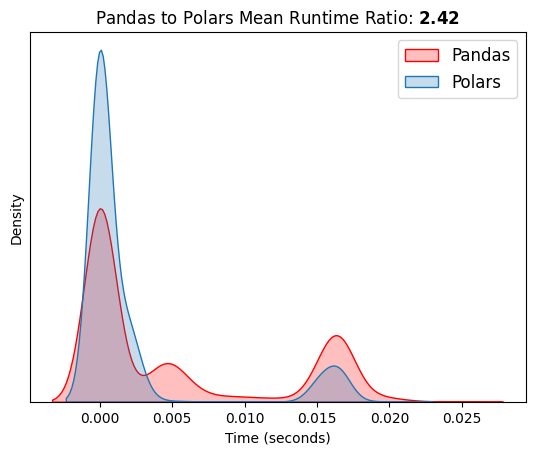

In [20]:
sns.kdeplot(times_2_pandas, fill=True, label='Pandas', color='red')
sns.kdeplot(times_2_polars, fill=True, label='Polars')
mean_runtime_ratio = np.mean(times_2_pandas) / np.mean(times_2_polars)
title_obj = plt.gca().title
title_obj.set_text(
    f'Pandas to Polars Mean Runtime Ratio: '
    r'$\mathbf{' + f'{mean_runtime_ratio:.2f}' + '}$')
plt.xlabel('Time (seconds)')
plt.legend(fontsize='large')
plt.yticks([])
plt.show();

#### Extra Plots to View the Relationship (If You Are Interested)

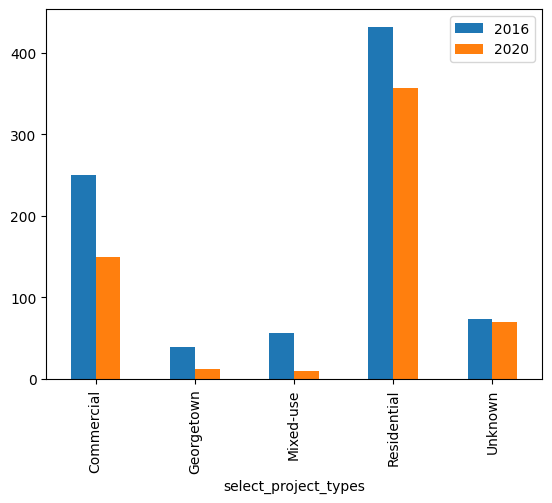

In [21]:
comparison.plot(kind='bar');

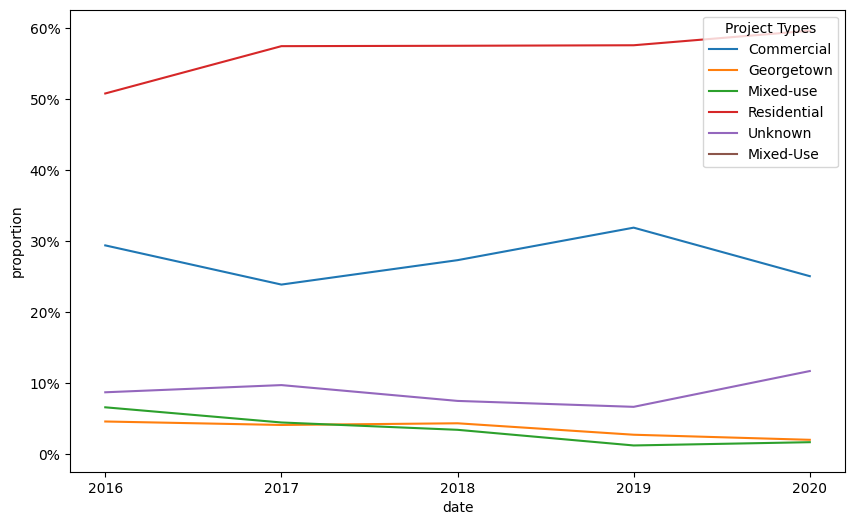

In [22]:
# Calculate proportions (look at the pandas code for reference for distribution)
distribution['proportion'] = distribution.groupby('date')['count'].transform(lambda x: x / x.sum())

plt.figure(figsize=(10, 6))
sns.lineplot(data=distribution, x="date", y="proportion", hue="select_project_types")
plt.legend(title='Project Types')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
plt.xticks(distribution['date'].unique())
plt.show()